# IPCV Assignment 1

Authors:

- Mauro Dore             - mauro.dore@studio.unibo.it            - 0001105149
- Gian Mario Marongiu    - gianmario.marongiu@studio.unibo.it    - 0001092260
- Riccardo Murgia        - riccardo.murgia2@studio.unibo.it      - 0001083930

## Imports and Auxiliary Functions

In [17]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import random

# Global seed value
seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
os.environ['PYTHONHASHSEED'] = str(seed_value)

#todo: sopprimere warning e togli codice prima di consegna


In [18]:
def show_multiple_images(image_list, cols=3, titles=None, global_title=None, plot_height=3):
    if not image_list:
        raise ValueError("The image list must not be empty.")

    num_images = len(image_list)

    if titles and len(titles) != num_images:
        raise ValueError("Titles list length must match the number of images.")

    rows = -(-num_images // cols)  # Equivalent to math.ceil

    fig, axes = plt.subplots(rows, cols, figsize=(10, plot_height * rows))
    fig.subplots_adjust(top=0.9 if global_title else 1.0)

    if global_title:
        fig.suptitle(global_title, fontsize=16, fontweight='bold')

    axes = axes.flatten() if num_images > 1 else [axes]

    for i, ax in enumerate(axes):
        if i < num_images:
            image = image_list[i]

            # Ensure the image is in an acceptable format (uint8)
            if image.dtype == np.float64:
                # Scale to 0-255 and convert to uint8
                image = np.uint8(np.clip(image * 255, 0, 255))

            # Handle both grayscale and color images
            if len(image.shape) == 2:  # Grayscale image (height, width)
                ax.imshow(image, cmap='gray')  # Use grayscale colormap for black-and-white images
            elif len(image.shape) == 3:  # Color image (height, width, channels)
                # Convert BGR to RGB if the image is in BGR format
                ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            else:
                raise ValueError(f"Image at index {i} has invalid shape: {image.shape}")

            ax.set_axis_off()
            if titles:
                ax.set_title(titles[i], fontsize=12, fontweight='bold')
        else:
            ax.set_visible(False)

    plt.tight_layout()
    plt.show()
    
def png_to_numpy(path, list):
    for image_name in os.listdir(path):
        image_path = os.path.join(path, image_name)
        image = cv2.imread(image_path)
        list.append(image)

def print_detection_summary_temporary(real_matchings, detected_matchings):
    print("Detection summary:")
    for scene in real_matchings.keys():
        scene_str = f"Scene {scene}".ljust(20)
        present_models_str = f"Models in the image: {real_matchings[scene]}".ljust(60)
        detected_models_str = f"Models detected: {detected_matchings[scene]}"
    
        print(f"{scene_str} {present_models_str} {detected_models_str}")

# todo: aggiungere alla print_summary il plotting delle occorrenze con bounding box
#todo: merging delle funzioni di Mauro
def print_single_detection_summary(real_matchings, detected_matchings, detected_matchings_positions):
    
    # detected_matchings_positions can be (0,)
    # detected_matchings_positions can be (4, 1, 2) -> single instance detection
    # detected_matchings_positions can be (N, 4, 1, 2) -> multi instance detection
    # MAUUUUUU -> Quel "1" nelle shape dei detected matching positions sono l'omogeneous coordinate, la stai gestendo?
    
    print("Detection summary:\n")
    for single_scene in real_matchings.keys():
        products = detected_matchings[single_scene]
        matching_position = detected_matchings_positions[single_scene]
        
        print("\n" + "- "*40)
        print(f"Scene {single_scene}\n")
        for index, prod in enumerate(products):
            top_left, bottom_left, bottom_right, top_right = matching_position[index]

            top_left = top_left[0]
            bottom_left = bottom_left[0]
            bottom_right = bottom_right[0]
            top_right = top_right[0]

            center_x = int((top_left[0] + bottom_left[0] + bottom_right[0] + top_right[0]) / 4)
            center_y = int((top_left[1] + bottom_left[1] + bottom_right[1] + top_right[1]) / 4)
            width = int(np.linalg.norm(top_left - top_right))
            height = int(np.linalg.norm(top_left - bottom_left))

            print(f"Product {index + 1} - {products.count(prod)} instance found:")
            print(f"Instance {index + 1} position: ({center_x}, {center_y}), width: {width}px, height: {height}px")

def print_multi_detection_summary(real_matchings, detected_matchings, detected_matchings_positions):
    print("Detection summary:")
    for scene in real_matchings.keys():
        products = detected_matchings[scene]
        matching_position = detected_matchings_positions[scene]
        
        print("\n" + "- "*40)
        print(f"Scene {scene}")
        for index, prod in enumerate(products):
            print(f"\nProduct {index + 1} - {prod[1]} instance found:")
            for coordinates in matching_position[index][1]:
                for idx, tup in enumerate(coordinates):
                    x_top_left, y_top_left, x_bottom_right, y_bottom_right = tup

                    center_x = int((x_top_left + x_bottom_right) / 2)
                    center_y = int((y_top_left + y_bottom_right) / 2)
                    width = int(np.linalg.norm(x_bottom_right - x_top_left))
                    height = int(np.linalg.norm(y_bottom_right - y_top_left))

                    print(f"Instance {idx + 1} position: ({center_x}, {center_y}), width: {width}px, height: {height}px")


In [19]:
def warp_model(model, homography, scene_shape):
    """
    Warps the entire model to the scene based on the homography matrix.
    Ensures that the warped model stays within the scene boundaries.
    """
    height, width = model.shape[:2]

    # Get the corner points of the model
    model_corners = np.float32([[0, 0], [0, height - 1], [width - 1, height - 1], [width - 1, 0]]).reshape(-1, 1, 2)

    # Warp the corner points to the scene using the homography matrix
    warped_corners = cv2.perspectiveTransform(model_corners, homography)

    # Get the bounding box of the warped model
    x_min = int(min(warped_corners[:, 0, 0]))
    x_max = int(max(warped_corners[:, 0, 0]))
    y_min = int(min(warped_corners[:, 0, 1]))
    y_max = int(max(warped_corners[:, 0, 1]))

    # Ensure the bounding box is within the scene boundaries
    h_scene, w_scene = scene_shape[:2]
    x_min = max(0, x_min)
    x_max = min(w_scene, x_max)
    y_min = max(0, y_min)
    y_max = min(h_scene, y_max)

    # Warp the entire model to the scene size using homography
    warped_model = cv2.warpPerspective(model, homography, (w_scene, h_scene))

    # Crop the corresponding region from the warped model and scene
    return warped_model[y_min:y_max, x_min:x_max], (x_min, y_min, x_max, y_max)

def zncc(patch1, patch2):
    # Subtract the mean from each patch (Zero mean)
    patch1_mean = patch1 - np.mean(patch1)
    patch2_mean = patch2 - np.mean(patch2)

    # Compute the numerator: sum of element-wise products of the zero-mean patches
    numerator = np.sum(patch1_mean * patch2_mean)

    # Compute the denominator: product of the standard deviations
    denominator = np.sqrt(np.sum(patch1_mean ** 2) * np.sum(patch2_mean ** 2))

    # Avoid division by zero
    if denominator == 0:
        return -1  # Return -1 if denominator is 0

    return numerator / denominator

def validate_matching(model, scene, homography, config):
    """
    Validate by comparing the entire warped model with the corresponding region in the scene.
    """
    # Warp the model and get the corresponding region in the scene
    model_warped, (x_min, y_min, x_max, y_max) = warp_model(model, homography, scene.shape)

    # Extract the corresponding region from the scene
    scene_region = scene[y_min:y_max, x_min:x_max]

    # Compare the entire warped model and the scene region using ZNCC
    zncc_score = zncc(model_warped, scene_region)
    return zncc_score > config["zncc_threshold"]


In [20]:
MODELS_SINGLE_INSTANCE_PATH = "models_single_instance"
SCENES_SINGLE_INSTANCE_PATH = "scenes_single_instance"
MODELS_MULTIPLE_INSTANCES_PATH = "models_multiple_instances"
SCENES_MULTIPLE_INSTANCES_PATH = "scenes_multiple_instances"

models_single_instance = []
scenes_single_instance = []
models_multiple_instances = []
scenes_multiple_instances = []

png_to_numpy(MODELS_SINGLE_INSTANCE_PATH, models_single_instance)
png_to_numpy(SCENES_SINGLE_INSTANCE_PATH, scenes_single_instance)
png_to_numpy(MODELS_MULTIPLE_INSTANCES_PATH, models_multiple_instances)
png_to_numpy(SCENES_MULTIPLE_INSTANCES_PATH, scenes_multiple_instances)
    
print(f"{len(models_single_instance)} models and {len(scenes_single_instance)} scenes for single instance detection task")
print(f"{len(models_multiple_instances)} models and {len(scenes_multiple_instances)} scenes for multiple instances detection task")


14 models and 5 scenes for single instance detection task
12 models and 7 scenes for multiple instances detection task


## Single Instance Detection

The objective is to perform instance detection using the provided model images. Several challenges must be addressed:

- The scenes contain significant noise, which must be mitigated prior to detection;
- The models are noticeably brighter than the scenes, indicating the need for a method that is robust to intensity variations;
- The models and scenes exhibit considerable variation in shape, necessitating the use of a scale-invariant detector.

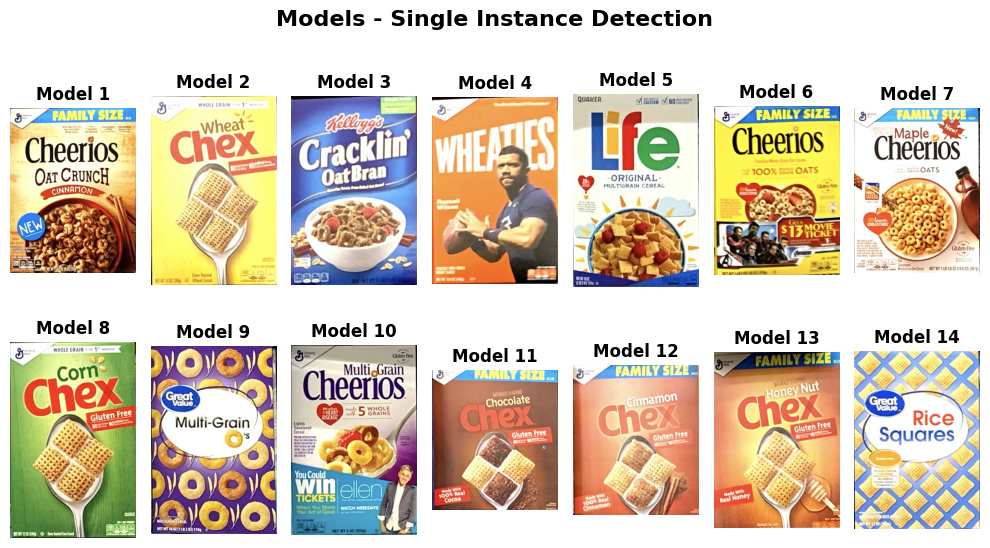

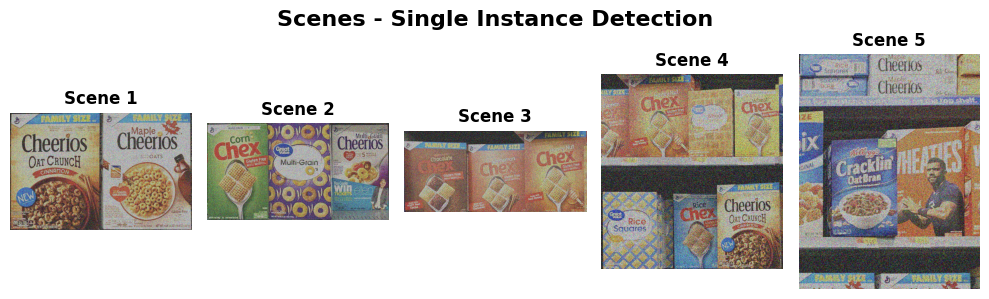

In [44]:
single_instance_real_matchings = {0: [0, 6], 1: [7, 8, 9], 2: [10, 11, 12], 3: [11, 12, 13, 1, 0], 4: [2, 3, 6]}

model_titles = [f"Model {i}" for i in range(1, 15)]
scene_titles = [f"Scene {i}" for i in range(1, 6)]
show_multiple_images(models_single_instance, cols=7, global_title="Models - Single Instance Detection", titles=model_titles)
show_multiple_images(scenes_single_instance, cols=5, global_title="Scenes - Single Instance Detection", titles=scene_titles)


### Scenes Denoising
The denoising phase is crucial to PULIRE le immagini bla bla. Here we collect the images denoised with the different pipelines tested in our experiments. Successively, these denoised images will be used to test how different incrementally complex techniques affects the results.

Main Pipeline - Scenes Denoising: 100%|██████████| 5/5 [00:01<00:00,  2.70it/s]


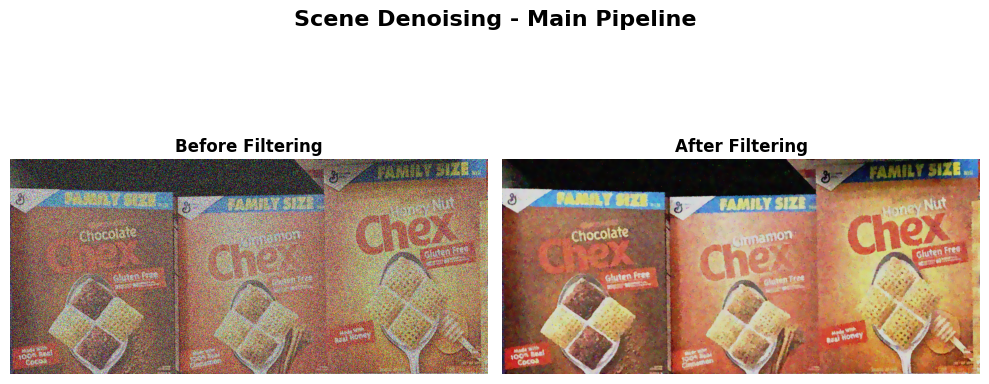

In [45]:
denoised_scenes_single_instance = []

for scene in tqdm(scenes_single_instance, desc="Main Pipeline - Scenes Denoising: "):
    denoised_scene = cv2.medianBlur(scene, 3)
    denoised_scene = cv2.medianBlur(denoised_scene, 3)
    denoised_scene = cv2.bilateralFilter(denoised_scene, d=19, sigmaColor=50, sigmaSpace=250)
    denoised_scene = cv2.bilateralFilter(denoised_scene, d=19, sigmaColor=20, sigmaSpace=100)
    denoised_scenes_single_instance.append(denoised_scene)

# example of a random denoised image
random_idx = np.random.randint(len(scenes_single_instance))
show_multiple_images([scenes_single_instance[random_idx], denoised_scenes_single_instance[random_idx]],
                     global_title=f"Scene Denoising - Main Pipeline",
                     titles=["Before Filtering", "After Filtering"],
                     cols=2,
                     plot_height=5)


### Detection Phase

In [23]:
def single_object_retrieve(model, scene, config):
    sift = cv2.SIFT_create()

    # Detect keypoints and compute descriptors
    keypoints_model, descriptors_model = sift.detectAndCompute(model, None)
    keypoints_scene, descriptors_scene = sift.detectAndCompute(scene, None)

    # FLANN parameters for matching
    flann = cv2.FlannBasedMatcher()

    # Match descriptors using k-NN (k=2)
    matches = flann.knnMatch(descriptors_model, descriptors_scene, k=2)

    # Lowe's ratio test to select good matches. m is first match, n is second match.
    good_matches = []
    for model_point, scene_point in matches:
        if model_point.distance < config["lowes_ratio_thresh"] * scene_point.distance:
            good_matches.append(model_point)

    # Ensure enough good matches were found
    if len(good_matches) < config["low_thresh_min_match"]:
        return False, scene, len(good_matches), None

    # Extract coordinates from the good matches
    model_points = np.float32([keypoints_model[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    scene_points = np.float32([keypoints_scene[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

    # Find homography matrix
    homography, mask = cv2.findHomography(model_points, scene_points, cv2.RANSAC, 5.0)

    # Validate using zncc
    matching_exceeds_high_threshold = len(good_matches) > config["high_thresh_min_match"]
    matching_exceeds_low_threshold = len(good_matches) > config["low_thresh_min_match"]
    patch_check_is_valid = validate_matching(model, scene, homography, config)

    if matching_exceeds_high_threshold or (matching_exceeds_low_threshold and patch_check_is_valid):
        height, width = model.shape[:2]
        model_corners = np.float32([[0, 0], [0, height - 1], [width - 1, height - 1], [width - 1, 0]]).reshape(-1, 1, 2)
        dst = cv2.perspectiveTransform(model_corners, homography)
        scene_boxed = cv2.polylines(np.array(scene), [np.int32(dst)], True, (0, 255, 0), 5, cv2.LINE_AA)

        return True, scene_boxed, len(good_matches), dst
    else:
        return False, scene, len(good_matches), None


In [24]:
config_single_instance = {
    # feature matching parameters
    "low_thresh_min_match": 15,
    "high_thresh_min_match": 200,
    "lowes_ratio_thresh": 0.65,

    # Zero normalized cross-correlation parameters
    "zncc_threshold": 0.6,
}

single_instance_detected_matchings = {scene: [] for scene in range(len(scenes_single_instance))}
single_instance_detected_matchings_positions = {scene: [] for scene in range(len(scenes_single_instance))}

total_iterations = len(models_single_instance) * len(scenes_single_instance)
with tqdm(total=total_iterations, desc=f"Instance detection") as pbar:
    for model_idx, model in enumerate(models_single_instance):
        for scene_idx, scene in enumerate(denoised_scenes_single_instance):
            found, scene_boxed, good_matches, dst = single_object_retrieve(model=model, scene=scene, config=config_single_instance)

            if found:
                single_instance_detected_matchings[scene_idx].append(model_idx)
                single_instance_detected_matchings_positions[scene_idx].append(np.int32(dst))

            pbar.update(1)

    print_detection_summary_temporary(single_instance_real_matchings, single_instance_detected_matchings)
    print_single_detection_summary(single_instance_real_matchings, single_instance_detected_matchings, single_instance_detected_matchings_positions)


Instance detection: 100%|██████████| 70/70 [00:41<00:00,  1.70it/s]

Detection summary:
Scene 0              Models in the image: [0, 6]                                  Models detected: [0, 6]
Scene 1              Models in the image: [7, 8, 9]                               Models detected: [7, 8, 9]
Scene 2              Models in the image: [10, 11, 12]                            Models detected: [10, 11, 12]
Scene 3              Models in the image: [11, 12, 13, 1, 0]                      Models detected: [0, 1, 11, 12, 13]
Scene 4              Models in the image: [2, 3, 6]                               Models detected: [2, 3, 6]
Detection summary:


- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Scene 0

Product 1 - 1 instance found:
Instance 1 position: (411, 538), width: 803px, height: 1049px
Product 2 - 1 instance found:
Instance 2 position: (1246, 532), width: 802px, height: 1049px

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Scene 1

Product 1 - 1 instance found:
Instance 1

### Ablation Study - Different Denoising Pipelines
Why did we use the system above? What changes when modifying the approach

Pipeline 2 - Scenes Denoising: 100%|██████████| 5/5 [00:00<00:00,  6.20it/s]


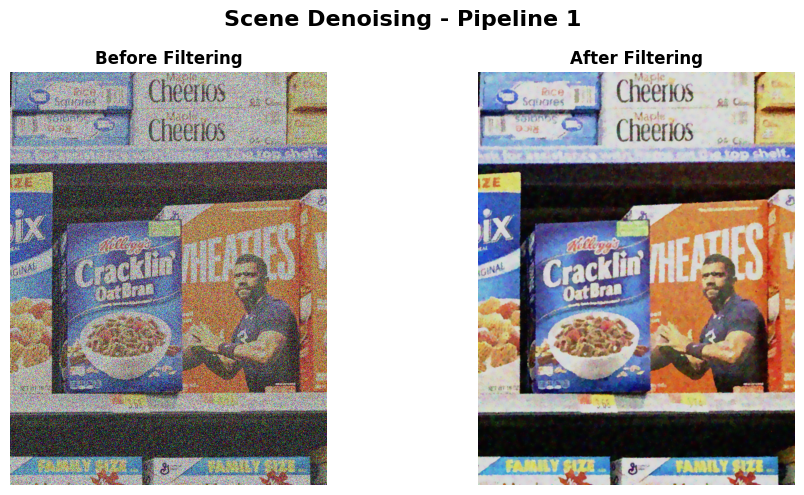

In [25]:
# todo: aggiungere discussione sui parametri del bilateralFilter
ablation_denoised_scenes_single_instance = {1: [], 2: []}

# First denoising pipeline
for scene in tqdm(scenes_single_instance, desc="Pipeline 1 - Scenes Denoising: "):
    denoised_scene = cv2.medianBlur(scene, 5)
    denoised_scene = cv2.bilateralFilter(denoised_scene, d=19, sigmaColor=50, sigmaSpace=250)
    ablation_denoised_scenes_single_instance[1].append(denoised_scene)

# Second denoising pipeline
for scene in tqdm(scenes_single_instance, desc="Pipeline 2 - Scenes Denoising: "):
    denoised_scene = cv2.medianBlur(scene, 3)
    denoised_scene = cv2.medianBlur(denoised_scene, 3)
    denoised_scene = cv2.bilateralFilter(denoised_scene, d=19, sigmaColor=50, sigmaSpace=250)
    ablation_denoised_scenes_single_instance[2].append(denoised_scene)

# example of a random denoised image
# todo: fare i plot di tutte le denoising
random_idx = np.random.randint(len(scenes_single_instance))
show_multiple_images([scenes_single_instance[random_idx], ablation_denoised_scenes_single_instance[1][random_idx]],
                     global_title=f"Scene Denoising - Pipeline 1",
                     titles=["Before Filtering", "After Filtering"],
                     cols=2,
                     plot_height=5)


In [26]:
for pipeline_version in ablation_denoised_scenes_single_instance.keys():
    single_instance_detected_matchings = {scene: [] for scene in range(len(scenes_single_instance))}
    single_instance_detected_matchings_positions = {scene: [] for scene in range(len(scenes_single_instance))}

    total_iterations = len(models_single_instance) * len(scenes_single_instance)
    with tqdm(total=total_iterations, desc=f"Instance detection with denoising pipeline {pipeline_version}") as pbar:
        for model_idx, model in enumerate(models_single_instance):
            for scene_idx, scene in enumerate(ablation_denoised_scenes_single_instance[pipeline_version]):
                found, scene_boxed, good_matches, dst = single_object_retrieve(model=model, scene=scene, config=config_single_instance)

                if found:
                    single_instance_detected_matchings[scene_idx].append(model_idx)
                    single_instance_detected_matchings_positions[scene_idx].append(np.int32(dst))

                pbar.update(1)

        print_detection_summary_temporary(single_instance_real_matchings, single_instance_detected_matchings)
        print_single_detection_summary(single_instance_real_matchings, single_instance_detected_matchings, single_instance_detected_matchings_positions)


Instance detection with denoising pipeline 1: 100%|██████████| 70/70 [00:35<00:00,  2.00it/s]


Detection summary:
Scene 0              Models in the image: [0, 6]                                  Models detected: [0, 6]
Scene 1              Models in the image: [7, 8, 9]                               Models detected: [7, 8, 9]
Scene 2              Models in the image: [10, 11, 12]                            Models detected: [10, 11, 12]
Scene 3              Models in the image: [11, 12, 13, 1, 0]                      Models detected: [0, 1, 11, 12, 13]
Scene 4              Models in the image: [2, 3, 6]                               Models detected: [0, 2, 3, 6]
Detection summary:


- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Scene 0

Product 1 - 1 instance found:
Instance 1 position: (411, 538), width: 803px, height: 1049px
Product 2 - 1 instance found:
Instance 2 position: (1247, 533), width: 803px, height: 1048px

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Scene 1

Product 1 - 1 instance found:
Instanc

Instance detection with denoising pipeline 2: 100%|██████████| 70/70 [00:57<00:00,  1.23it/s]

Detection summary:
Scene 0              Models in the image: [0, 6]                                  Models detected: [0, 6]
Scene 1              Models in the image: [7, 8, 9]                               Models detected: [7, 8, 9]
Scene 2              Models in the image: [10, 11, 12]                            Models detected: [10, 11, 12]
Scene 3              Models in the image: [11, 12, 13, 1, 0]                      Models detected: [0, 1, 11, 12, 13]
Scene 4              Models in the image: [2, 3, 6]                               Models detected: [2, 3]
Detection summary:


- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Scene 0

Product 1 - 1 instance found:
Instance 1 position: (411, 538), width: 801px, height: 1048px
Product 2 - 1 instance found:
Instance 2 position: (1247, 533), width: 802px, height: 1049px

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Scene 1

Product 1 - 1 instance found:
Instance 1 po

### Different low and high thresholds

In [27]:
# todo: discutere lowes ratio - Caso 1: (entrambe le threshold a 0) -> ZNCC viene eseguita a prescindere su tutti i possibili matching
# todo: discutere lowes ratio - Caso 2: (low a 0) -> facciamo ZNCC a prescindere su tutto ciò che non supera la high threshold
# todo: discutere lowes ratio - Caso 2: (high a 100) -> vedere come si comporta

config_single_instance = {
    # feature matching parameters
    "low_thresh_min_match": 15,
    "high_thresh_min_match": 200,
    "lowes_ratio_thresh": 0.65,

    # Zero normalized cross-correlation parameters
    "zncc_threshold": 0.6,
}

single_instance_detected_matchings = {scene: [] for scene in range(len(scenes_single_instance))}
single_instance_detected_matchings_positions = {scene: [] for scene in range(len(scenes_single_instance))}

total_iterations = len(models_single_instance) * len(scenes_single_instance)
with tqdm(total=total_iterations, desc=f"Instance detection") as pbar:
    for model_idx, model in enumerate(models_single_instance):
        for scene_idx, scene in enumerate(denoised_scenes_single_instance):
            found, scene_boxed, good_matches, dst = single_object_retrieve(model=model, scene=scene, config=config_single_instance)

            if found:
                single_instance_detected_matchings[scene_idx].append(model_idx)
                single_instance_detected_matchings_positions[scene_idx].append(np.int32(dst))

            pbar.update(1)

    print_detection_summary_temporary(single_instance_real_matchings, single_instance_detected_matchings)
    print_single_detection_summary(single_instance_real_matchings, single_instance_detected_matchings, single_instance_detected_matchings_positions)


Instance detection: 100%|██████████| 70/70 [00:46<00:00,  1.51it/s]

Detection summary:
Scene 0              Models in the image: [0, 6]                                  Models detected: [0, 6]
Scene 1              Models in the image: [7, 8, 9]                               Models detected: [7, 8, 9]
Scene 2              Models in the image: [10, 11, 12]                            Models detected: [10, 11, 12]
Scene 3              Models in the image: [11, 12, 13, 1, 0]                      Models detected: [0, 1, 11, 12, 13]
Scene 4              Models in the image: [2, 3, 6]                               Models detected: [2, 3]
Detection summary:


- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Scene 0

Product 1 - 1 instance found:
Instance 1 position: (411, 538), width: 803px, height: 1048px
Product 2 - 1 instance found:
Instance 2 position: (1246, 532), width: 803px, height: 1050px

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Scene 1

Product 1 - 1 instance found:
Instance 1 po

### Different lowes ratio

In [28]:
# todo: discutere lowes ration -> testiamo [0.5, 0.8] a intervallo di 0.10

config_single_instance = {
    # feature matching parameters
    "low_thresh_min_match": 15,
    "high_thresh_min_match": 200,
    "lowes_ratio_thresh": 0.65,

    # Zero normalized cross-correlation parameters
    "zncc_threshold": 0.6,
}

single_instance_detected_matchings = {scene: [] for scene in range(len(scenes_single_instance))}
single_instance_detected_matchings_positions = {scene: [] for scene in range(len(scenes_single_instance))}

total_iterations = len(models_single_instance) * len(scenes_single_instance)
with tqdm(total=total_iterations, desc=f"Instance detection") as pbar:
    for model_idx, model in enumerate(models_single_instance):
        for scene_idx, scene in enumerate(denoised_scenes_single_instance):
            found, scene_boxed, good_matches, dst = single_object_retrieve(model=model, scene=scene, config=config_single_instance)

            if found:
                single_instance_detected_matchings[scene_idx].append(model_idx)
                single_instance_detected_matchings_positions[scene_idx].append(np.int32(dst))

            pbar.update(1)

    print_detection_summary_temporary(single_instance_real_matchings, single_instance_detected_matchings)
    print_single_detection_summary(single_instance_real_matchings, single_instance_detected_matchings, single_instance_detected_matchings_positions)


Instance detection: 100%|██████████| 70/70 [00:40<00:00,  1.72it/s]

Detection summary:
Scene 0              Models in the image: [0, 6]                                  Models detected: [0, 6]
Scene 1              Models in the image: [7, 8, 9]                               Models detected: [7, 8, 9]
Scene 2              Models in the image: [10, 11, 12]                            Models detected: [10, 11, 12]
Scene 3              Models in the image: [11, 12, 13, 1, 0]                      Models detected: [0, 1, 11, 12, 13]
Scene 4              Models in the image: [2, 3, 6]                               Models detected: [2, 3, 6]
Detection summary:


- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Scene 0

Product 1 - 1 instance found:
Instance 1 position: (411, 538), width: 803px, height: 1050px
Product 2 - 1 instance found:
Instance 2 position: (1247, 533), width: 802px, height: 1048px

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Scene 1

Product 1 - 1 instance found:
Instance 1

### Different ZNCC ratio

In [29]:
# todo: discutere zncc_threshold -> testiamo [0.4, 0.8] a intervalli di 0.10

config_single_instance = {
    # feature matching parameters
    "low_thresh_min_match": 15,
    "high_thresh_min_match": 200,
    "lowes_ratio_thresh": 0.65,

    # Zero normalized cross-correlation parameters
    "zncc_threshold": 0.6,
}

single_instance_detected_matchings = {scene: [] for scene in range(len(scenes_single_instance))}
single_instance_detected_matchings_positions = {scene: [] for scene in range(len(scenes_single_instance))}

total_iterations = len(models_single_instance) * len(scenes_single_instance)
with tqdm(total=total_iterations, desc=f"Instance detection") as pbar:
    for model_idx, model in enumerate(models_single_instance):
        for scene_idx, scene in enumerate(denoised_scenes_single_instance):
            found, scene_boxed, good_matches, dst = single_object_retrieve(model=model, scene=scene, config=config_single_instance)

            if found:
                single_instance_detected_matchings[scene_idx].append(model_idx)
                single_instance_detected_matchings_positions[scene_idx].append(np.int32(dst))

            pbar.update(1)

    print_detection_summary_temporary(single_instance_real_matchings, single_instance_detected_matchings)
    print_single_detection_summary(single_instance_real_matchings, single_instance_detected_matchings, single_instance_detected_matchings_positions)


Instance detection: 100%|██████████| 70/70 [00:41<00:00,  1.68it/s]

Detection summary:
Scene 0              Models in the image: [0, 6]                                  Models detected: [0, 6]
Scene 1              Models in the image: [7, 8, 9]                               Models detected: [7, 8, 9]
Scene 2              Models in the image: [10, 11, 12]                            Models detected: [10, 11, 12]
Scene 3              Models in the image: [11, 12, 13, 1, 0]                      Models detected: [0, 1, 12, 13]
Scene 4              Models in the image: [2, 3, 6]                               Models detected: [2, 3]
Detection summary:


- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Scene 0

Product 1 - 1 instance found:
Instance 1 position: (411, 538), width: 803px, height: 1049px
Product 2 - 1 instance found:
Instance 2 position: (1246, 532), width: 803px, height: 1050px

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Scene 1

Product 1 - 1 instance found:
Instance 1 positi

## Multiple Instances Detection

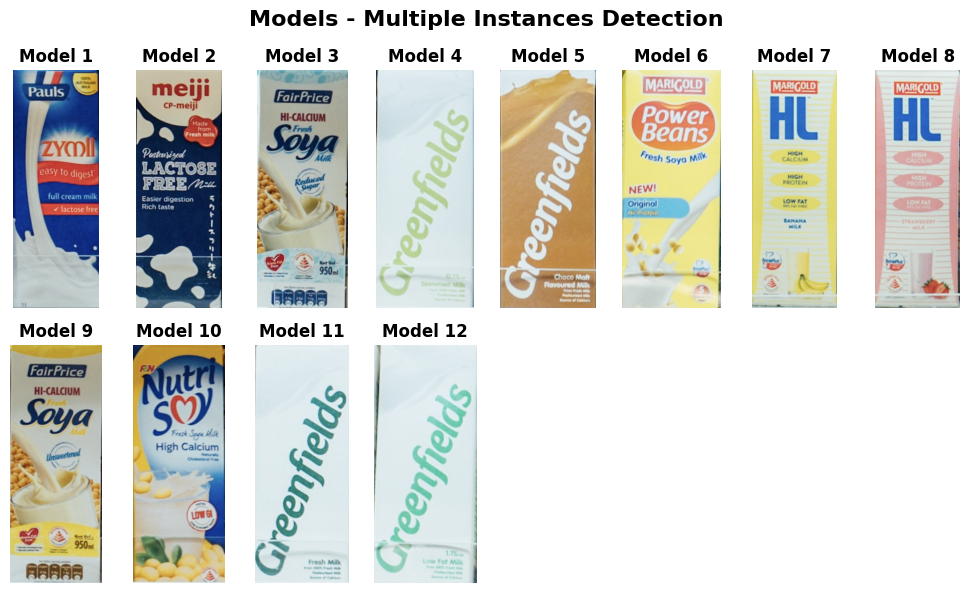

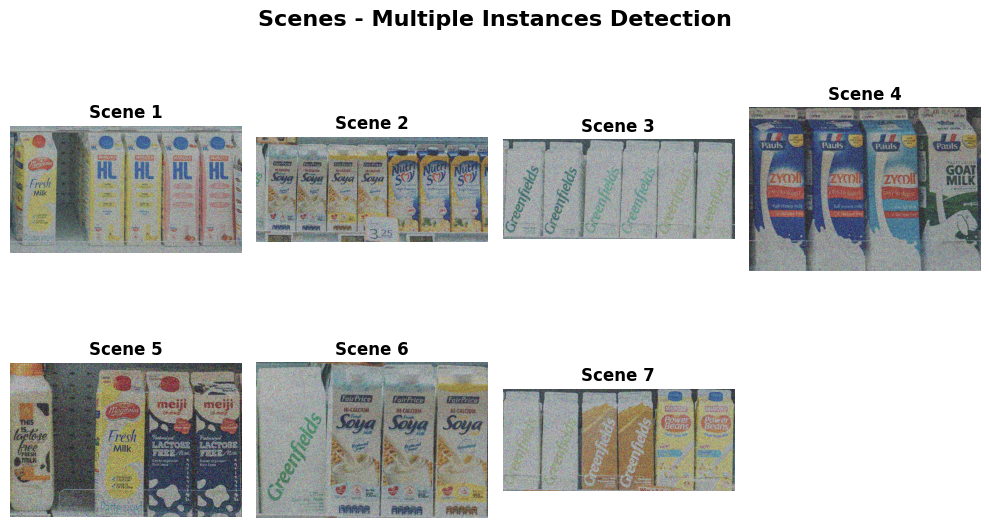

In [42]:
multi_instance_real_matchings = {0: [(6, 2), (7, 2)],
                                 1: [(2, 2), (8, 2), (9, 3)], 
                                 2: [(10, 2), (11, 2), (3, 2)], 
                                 3: [(0, 2)],
                                 4: [(1, 2)],
                                 5: [(2, 2), (8, 1)],
                                 6: [(3, 2), (4, 2), (5, 2)]}

model_titles = [f"Model {i}" for i in range(1, 13)]
scene_titles = [f"Scene {i}" for i in range(1, 8)]
show_multiple_images(models_multiple_instances, cols=8, global_title="Models - Multiple Instances Detection", titles=model_titles)
show_multiple_images(scenes_multiple_instances, cols=4, global_title="Scenes - Multiple Instances Detection", titles=scene_titles)


### Scene Denoising

Main Pipeline - Scenes Denoising: 100%|██████████| 7/7 [00:02<00:00,  3.24it/s]


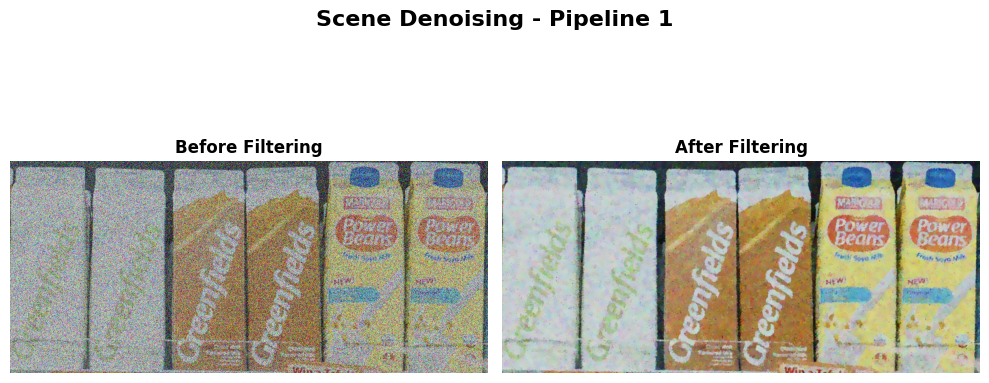

In [31]:
denoised_scenes_multiple_instance = []

for scene in tqdm(scenes_multiple_instances, desc="Main Pipeline - Scenes Denoising: "):
    denoised_scene = cv2.medianBlur(scene, 3)
    denoised_scene = cv2.medianBlur(denoised_scene, 3)
    denoised_scene = cv2.bilateralFilter(denoised_scene, d=19, sigmaColor=50, sigmaSpace=250)
    denoised_scene = cv2.bilateralFilter(denoised_scene, d=19, sigmaColor=20, sigmaSpace=100)
    denoised_scenes_multiple_instance.append(denoised_scene)

# example of a random denoised image
# todo: cabia nome al plot e alla pipeline principale
random_idx = np.random.randint(len(scenes_multiple_instances))
show_multiple_images([scenes_multiple_instances[random_idx], denoised_scenes_multiple_instance[random_idx]],
                     global_title=f"Scene Denoising - Pipeline 1",
                     titles=["Before Filtering", "After Filtering"],
                     cols=2,
                     plot_height=5)


### Detection Phase

In [32]:
def multi_object_retrieve(model, scene, config):
    sift = cv2.SIFT_create()

    # Detect keypoints and compute descriptors
    keypoints_model, descriptors_model = sift.detectAndCompute(model, None)
    keypoints_scene, descriptors_scene = sift.detectAndCompute(scene, None)

    # FLANN parameters for matching
    flann = cv2.FlannBasedMatcher()

    # Match descriptors using k-NN
    matches = flann.knnMatch(descriptors_model, descriptors_scene, k=2)
    good_matches = []

    for model_point, scene_point in matches:
        if model_point.distance < config["lowes_ratio_thresh"] * scene_point.distance:
            good_matches.append(model_point)

    model_keypoints = np.float32([keypoints_model[m.queryIdx].pt for m in good_matches]).reshape(-1, 2)
    scene_keypoints = np.float32([keypoints_scene[m.trainIdx].pt for m in good_matches]).reshape(-1, 2)

    occurrences_found = 0
    occurrence_positions = []
    scene_boxed = scene.copy()

    # homography calculation requires at least 4 points for computation
    while len(model_keypoints) > 4:
        homography, mask = cv2.findHomography(model_keypoints, scene_keypoints, cv2.RANSAC, 5.0)

        if homography is None:
            break

        # Validate using zncc
        matching_points_exceeds_threshold = len(scene_keypoints) > config["threshold_matches"]
        patch_is_valid = validate_matching(model, scene, homography, config)

        if matching_points_exceeds_threshold and patch_is_valid:
            height, width = model.shape[:2]
            model_corners = np.float32([[0, 0], [0, height - 1], [width - 1, height - 1], [width - 1, 0]]).reshape(-1, 1, 2)
            dst = cv2.perspectiveTransform(model_corners, homography)
            scene_boxed = cv2.polylines(scene_boxed, [np.int32(dst)], True, (0, 255, 0), 5, cv2.LINE_AA)

            occurrences_found += 1
            occurrence_positions.append(dst)

            mask = mask.squeeze().astype("bool")
            scene_keypoints = scene_keypoints[~mask]
            model_keypoints = model_keypoints[~mask]
        else:
            break
    
    if occurrences_found > 0:
        return True, scene_boxed, occurrences_found, occurrence_positions
    else:
        return False, scene, 0, []


In [33]:
#todo: cancella
def compute_metrics(real_occurrences, predicted_occurrences):
    # Initialize variables to track TP, FP, FN
    true_positives = 0
    false_positives = 0
    false_negatives = 0

    # Iterate over each class/key in real occurrences
    for key in real_occurrences:
        real_set = set(real_occurrences[key])
        predicted_set = set(predicted_occurrences.get(key, []))

        # Compute true positives (correct predictions)
        tp = len(real_set & predicted_set)

        # Compute false positives (wrong predictions)
        fp = len(predicted_set - real_set)

        # Compute false negatives (missed real occurrences)
        fn = len(real_set - predicted_set)

        # Update counts
        true_positives += tp
        false_positives += fp
        false_negatives += fn

    # Calculate precision, recall, and F1 score
    precision = true_positives / (true_positives + false_positives) if true_positives + false_positives > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if true_positives + false_negatives > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0

    # Return the metrics
    return precision, recall, f1

In [34]:
config_multi_instance = {
    # feature matching parameters
    "threshold_matches": 10,
    "lowes_ratio_thresh": 0.8,

    # Zero normalized cross-correlation parameters
    "zncc_threshold": 0.6
}

multi_model_scene_couples = []
multi_instance_detected_matchings = {scene: [] for scene in range(len(scenes_multiple_instances))}
multi_instance_detected_matchings_positions = {scene: [] for scene in range(len(scenes_multiple_instances))}

total_iterations = len(models_multiple_instances) * len(scenes_multiple_instances)
with tqdm(total=total_iterations, desc="Processing Models and Scenes") as pbar:
    for model_idx, model in enumerate(models_multiple_instances):
        for scene_idx, scene in enumerate(denoised_scenes_multiple_instance):
            
            found, scene_boxed, n_occurrences, occurrence_positions = multi_object_retrieve(model=model, scene=scene, config=config_multi_instance)
            multi_model_scene_couples.append([model, scene_boxed, found, n_occurrences])

            if found:
                multi_instance_detected_matchings[scene_idx].append((model_idx, n_occurrences))
                #multi_instance_detected_matchings_positions[scene_idx].append((model_idx, [occurrence_positions]))

            pbar.update(1)

print_multi_detection_summary(multi_instance_real_matchings, multi_instance_detected_matchings, multi_instance_detected_matchings_positions)
precision, recall, F1 = compute_metrics(multi_instance_real_matchings, multi_instance_detected_matchings)
print("F1: ", F1)


Processing Models and Scenes: 100%|██████████| 84/84 [00:35<00:00,  2.38it/s]

Detection summary:

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Scene 0

Product 1 - 1 instance found:


IndexError: list index out of range

### Ablation Study - Different Denoising Pipelines
Why did we use the system above? What changes when modifying the approach

In [ ]:
# todo: aggiungere discussione sui parametri del bilateralFilter
ablation_denoised_scenes_multi_instance = {1: [], 2: []}

# First denoising pipeline
for scene in tqdm(scenes_multiple_instances, desc="Pipeline 1 - Scenes Denoising: "):
    denoised_scene = cv2.medianBlur(scene, 5)
    denoised_scene = cv2.bilateralFilter(denoised_scene, d=19, sigmaColor=50, sigmaSpace=250)
    ablation_denoised_scenes_multi_instance[1].append(denoised_scene)

# Second denoising pipeline
for scene in tqdm(scenes_multiple_instances, desc="Pipeline 2 - Scenes Denoising: "):
    denoised_scene = cv2.medianBlur(scene, 3)
    denoised_scene = cv2.medianBlur(denoised_scene, 3)
    denoised_scene = cv2.bilateralFilter(denoised_scene, d=19, sigmaColor=50, sigmaSpace=250)
    ablation_denoised_scenes_multi_instance[2].append(denoised_scene)

# example of a random denoised image
# todo: fare i plot di tutte le denoising
"""random_idx = np.random.randint(len(scenes_multiple_instances))
show_multiple_images([scenes_multiple_instances[random_idx], ablation_denoised_scenes_multi_instance[1][random_idx]],
                     global_title=f"Scene Denoising - Pipeline 1",
                     titles=["Before Filtering", "After Filtering"],
                     cols=2,
                     plot_height=5)""";


In [ ]:
for pipeline_version in ablation_denoised_scenes_multi_instance.keys():
    multi_instance_detected_matchings = {scene: [] for scene in range(len(scenes_multiple_instances))}
    total_iterations = len(models_multiple_instances) * len(scenes_multiple_instances)
    with tqdm(total=total_iterations, desc=f"Instance detection with denoising pipeline {pipeline_version}") as pbar:
        for model_idx, model in enumerate(models_multiple_instances):
            for scene_idx, scene in enumerate(ablation_denoised_scenes_multi_instance[pipeline_version]):

                found, scene_boxed, n_occurrences = multi_object_retrieve(model=model, scene=scene, config=config_multi_instance)
                multi_model_scene_couples.append([model, scene_boxed, found, n_occurrences])

                if found:
                    multi_instance_detected_matchings[scene_idx].append((model_idx, n_occurrences))

                pbar.update(1)

        print_detection_summary(multi_instance_real_matchings, multi_instance_detected_matchings)
        precision, recall, F1 = compute_metrics(multi_instance_real_matchings, multi_instance_detected_matchings)
        print("F1: ", F1)


In [ ]:
#todo: ablation
